In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from DiceTowerVision import *
import datetime
cam_id = 1
camera_resolution = (2592,1944)
gui_resolution = (1280,400)
gui_text_zone = (0,0,280,400)
gui_scene_zone = (280,0,400,400)
gui_sample_zone = (680,0,600,400)

background_file_template = "Images\\Calibration\\background (*).jpg"
roll_file_template = "Images\\Rolls\\New\\FN#.jpg"

background_images_RGB = get_mactching_images_RGB(background_file_template,log_level=LOG_LEVEL_INFO)
roi_mask = get_roi_mask_from_bg_images(background_images_RGB,range=(0,10), filter=25, dilation=5, log_level=LOG_LEVEL_INFO)

# calibration_file = "Images\\Calibration\\calibration (1).jpg"
# cal_BGR = cv.imread(calibration_file)
# map_x, map_y = calibrate_from_checkerboard(cv.cvtColor(cal_BGR,cv.COLOR_BGR2GRAY),(10,10))

file_template = "Images\\Templates\\DDR# (A) (FV#).jpg"
dieset = DieSet.create_common_die_set_from_images(file_template,names=[4,6,8,10,12,20,100],roi_mask=roi_mask,log_level=LOG_LEVEL_WARN)
#dieset = DieSet.create_common_die_set_from_images(file_template,names=[4],roi_mask=roi_mask,log_level=LOG_LEVEL_WARN)


Initializing...


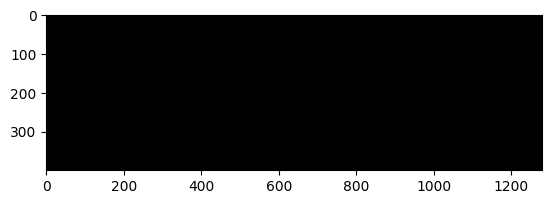

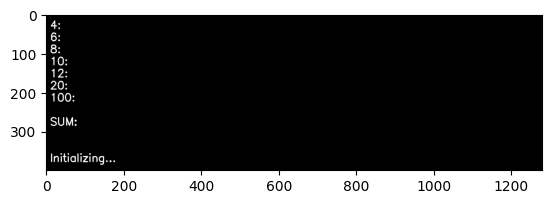

Tray cleared.
Motion detected!
Motion ended.
Images\Rolls\New\20240923-151041.jpg


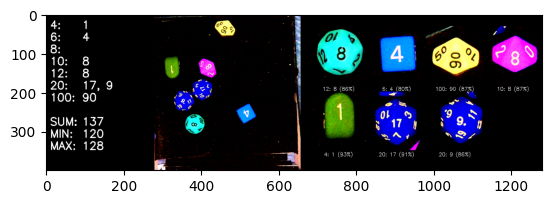

Image captured. Waiting for tray to clear
Motion detected!
Tray cleared.
Motion ended.
Images\Rolls\New\20240923-151301.jpg


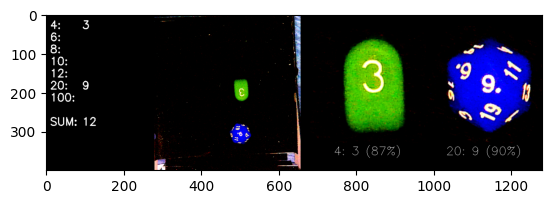

Image captured. Waiting for tray to clear
Motion detected!
Tray cleared.
Motion ended.
Images\Rolls\New\20240923-151341.jpg


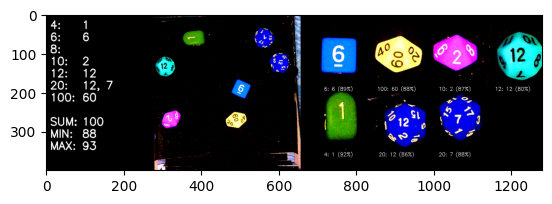

Image captured. Waiting for tray to clear
Motion detected!
Motion ended.
Tray cleared.
Motion detected!
Motion ended.
Images\Rolls\New\20240923-151609.jpg


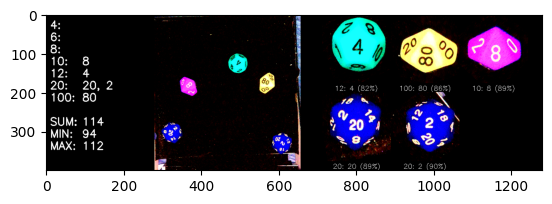

Image captured. Waiting for tray to clear
Motion detected!
Tray cleared.


In [2]:
motion_history = 5
motion_ratio = 1 - 1/motion_history
motion_detector = cv.createBackgroundSubtractorMOG2(history=motion_history)
fg_detector = cv.createBackgroundSubtractorMOG2()
camera = cv.VideoCapture(cam_id, cv.CAP_DSHOW)
if not camera.isOpened():
    print("Camera is not connected!")
camera.set(cv.CAP_PROP_FRAME_WIDTH, camera_resolution[0])
camera.set(cv.CAP_PROP_FRAME_HEIGHT, camera_resolution[1])

result_view_scale = 0.25

fid = 0
tray_mask = cv.morphologyEx(roi_mask,cv.MORPH_ERODE, get_kernel(5), iterations=50)
fg_threshold = 1.0
motion_start_threshold = 0.1
motion_end_threshold = 0.01
motion_active = False
image_captured = True
print("Initializing...")
cv.destroyAllWindows()
cv.namedWindow("View",cv.WINDOW_AUTOSIZE | cv.WINDOW_KEEPRATIO | cv.WINDOW_GUI_NORMAL)
cv.setWindowProperty("View", cv.WND_PROP_FULLSCREEN, cv.WINDOW_FULLSCREEN)
#cv.setWindowProperty("View", cv.WND_PROP_ASPECT_RATIO, cv.WINDOW_KEEPRATIO)
gui_image = np.zeros((gui_resolution[1],gui_resolution[0],3), dtype=np.uint8)
cv.imshow("View",gui_image)
plt.imshow(gui_image)
plt.show()
cv.waitKey(1)

_, image_BGR = camera.read()
dieset.draw_gui(gui_image, image_BGR, None, gui_text_zone, gui_scene_zone, gui_sample_zone, scene_roi=roi_mask, message="Initializing...")
plt.imshow(gui_image)
plt.show()
cv.imshow("View",gui_image)
cv.waitKey(1)



while True:
    fid += 1
    result, image_BGR = camera.read()
    if image_BGR is None:
        print(str(result))
        break
    
    # image_BGR_small = cv.resize(image_BGR,None,fx=0.25,fy=0.25,interpolation=cv.INTER_AREA)
    # cv.imshow('Frame',image_BGR_small)

    image_GRAY = cv.bitwise_and(cv.cvtColor(image_BGR, cv.COLOR_BGR2GRAY),tray_mask)
    image_blur = cv.medianBlur(image_GRAY,5)
    image = cv.inRange(image_blur,DieFaceSample.backround_brightness_threshold,255)
    motion_mask = motion_detector.apply(image)
    fg_sum = np.mean(image)
    motion_sum = np.mean(motion_mask)

    if fid > 2*motion_history: #wait for motion detector to stabalize
        if fg_sum > fg_threshold: #dice detected
            if not motion_active:
                if motion_sum > motion_start_threshold:
                    print("Motion detected!")
                    motion_active = True
            if motion_active:
                if motion_sum < motion_end_threshold: #dice at rest
                    print("Motion ended.")
                    motion_active = False
                    if not image_captured:
                        dieset.draw_gui(gui_image, image_BGR, None, gui_text_zone, gui_scene_zone, gui_sample_zone, roi_mask, "Calculating...")
                        image_RGB = cv.cvtColor(image_BGR, cv.COLOR_BGR2RGB)
                        # image_display = dieset.overlay_results_on_image(image_RGB,None,None,roi_mask=roi_mask,log_level=LOG_LEVEL_INFO)
                        cv.imshow("View",gui_image)
                        keypress = cv.waitKey(1)
                        roll_file_name = roll_file_template.replace("FN#",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
                        print(roll_file_name)
                        cv.imwrite(roll_file_name, image_BGR)
                        results = dieset.get_die_faces_from_image(image_RGB,face_confidence=0.5, rank_confidence=0.5,roi_mask=roi_mask,log_level=LOG_LEVEL_WARN)
                        #image_display = dieset.overlay_results_on_image(image_RGB,results,minmax_die='20',roi_mask=roi_mask,log_level=LOG_LEVEL_INFO)
                        dieset.draw_gui(gui_image, image_BGR, results, gui_text_zone, gui_scene_zone, gui_sample_zone, roi_mask)
                        cv.imshow("View",gui_image)
                        plt.imshow(gui_image)
                        plt.show()
                        print("Image captured. Waiting for tray to clear")
                        image_captured = True
                else: #dice in motion
                    if not image_captured:
                        dieset.draw_gui(gui_image, image_BGR, None, gui_text_zone, gui_scene_zone, gui_sample_zone, roi_mask, "Dice Rolling...")
                        cv.imshow('View',gui_image)
                    # else do not update result view because we are waiting on the tray to clear
                
        else: #no dice detected
            if image_captured: #reset because the tray is now empty
                image_captured = False
                print("Tray cleared.")
            
            dieset.draw_gui(gui_image, image_BGR, None, gui_text_zone, gui_scene_zone, gui_sample_zone, roi_mask, "Roll Dice")
            cv.imshow('View',gui_image)
    else:
        dieset.draw_gui(gui_image, image_BGR, None, gui_text_zone, gui_scene_zone, gui_sample_zone, scene_roi=roi_mask, message="Calibrating (%u%%)"%(100*fid/(2*motion_history)))
        cv.imshow('View',gui_image)
    #print("%u: FG=%f ; MOTION=%f ; MO/CAP=%s/%s"%(fid,fg_sum, motion_sum,str(motion_active),str(image_captured)))

    keypress = cv.waitKey(10)
    if keypress == 'q' or keypress == 27:
        break

    
cv.destroyAllWindows()